## 컴퓨터 비전에서 딥러닝이 활용되기 시작한 대표적인 모델 AlexNet을 파이토치 구현

### 논문 링크: https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

## 데이터셋 다운로드 훈련용 50만장, 검증용 10만장

In [1]:
!pip install natsort opencv-python tqdm


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import shutil
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import cv2
import torchvision.transforms as T
import natsort
from tqdm import tqdm


In [3]:
# 다운로드 안했으면 주석해제
# torchvision.datasets.INaturalist(root='./data',version='2021_train_mini', download=True)
# torchvision.datasets.INaturalist(root='./data',version='2021_valid', download=True)

## 데이터의 클래스 수가 10000개고 이미지만 60만장이므로 전체 학습하고 싶으면 서버 gpu 분산학습

In [4]:
class INaturalist_Dataset(Dataset):
    def __init__(self, train='train', transforms=None):
        self.root_path = 'data/2021_train_mini' if train=='train' else 'data/2021_valid'
      
        self.class_names = [class_name for class_name in natsort.natsorted(os.listdir(self.root_path))]
        self.data_path = []
        for class_idx, class_name in enumerate(self.class_names):
            for file in os.listdir(os.path.join(self.root_path, class_name)):
                self.data_path.append({'file_path':os.path.join(self.root_path, class_name, file), 'class_idx':class_idx})
        self.transforms = transforms
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self, idx):
        file_path = self.data_path[idx]['file_path']
        class_idx =  self.data_path[idx]['class_idx']
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, class_idx

## 데이터증강 

In [5]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    normalize
])

val_transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    T.Resize((224, 224)),
   
    normalize
])

In [6]:
batch_size = 32
trainset = INaturalist_Dataset('train', train_transform)
testset = INaturalist_Dataset('val', val_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

In [7]:
# trainset = torchvision.datasets.STL10('./data', split='train', download=True, transform=train_transform)
# testset = torchvision.datasets.STL10('./data', split='test', download=True, transform=val_transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=0)


# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=0)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


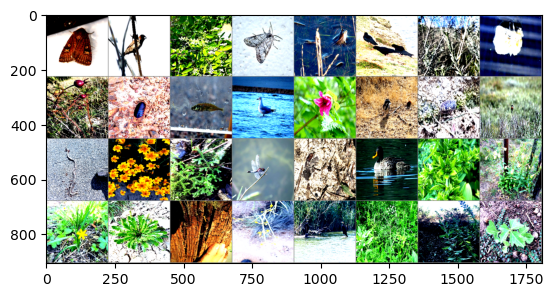

IndexError: list index out of range

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
classes = [class_name.split('_')[-2]+'_'+class_name.split('_')[-1] 
           for class_name in natsort.natsorted(os.listdir('data/2021_train_mini'))[:300]]

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## AlexNet 구현

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5):
        """
        num_classes: 분류할 클래스 개수
        dropout: dropout의 확률 값
        """
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        """
        이미지에서 특징 추출
        입력 이미지가 224, 224, 3이면 x는 배치크기, 3, 224, 224임
        """
         
        x = self.features(x)
        # x => 배치 크기, 256 ,6, 6
        
        x = self.avgpool(x)
        # avgpool을 하는 이유는 분류를 위해서 벡터화를 해줘야하는데 fc layer의 경우 입력 크기가 고정적이므로 특정 크기로 맞춰 주기 위해
        x = torch.flatten(x, 1)
        # x => 배치 크기, 256 ,6, 6 텐서를 벡터화 b, 256 * 6 * 6 크기로
        x = self.classifier(x)
        # 분류를 하기 위한 fc layer
        return x

## 모델 학습

In [ ]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AlexNet(10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 30
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
def train(loader, model,optimizer, criterion):
    running_loss = 0.0
    
    correct = 0
    total = 0

    model.train()
    for i, data in enumerate(tqdm(loader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
    epoch_loss = running_loss /len(loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [ ]:
def validation(loader, model, optimizer, criterion):
    running_loss = 0.0
    
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(loader), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()



            # print statistics
            running_loss += loss.item()
    epoch_loss = running_loss /len(loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

## 성능 테스트 진행
### 정확도는 높지 않을꺼임 데이터 수가 적음 제대로 학습 하고 싶으면 전체 데이터 사용해서 학습 

In [ ]:
best_acc = 0
for epoch in range(epochs):  # loop over the dataset multiple times
    

    train_loss, train_acc = train(trainloader,model, optimizer, criterion)
    val_loss, val_acc = validation(testloader,model, optimizer, criterion)
    scheduler.step()
    is_best = val_acc > best_acc
    best_acc1 = max(val_acc, best_acc)
    
    
    save_checkpoint({
            'epoch': epoch + 1,

            'state_dict': model.state_dict(),
            'best_acc1': best_acc,
            'optimizer' : optimizer.state_dict(),
            'scheduler' : scheduler.state_dict()
        }, is_best)
        
    print(f'[{epoch}], train_loss:{train_loss:.4f}, val_loss:{val_loss:.4f}, train_acc:{train_acc*100:.4f}, val_acc:{val_acc*100:.4f}')
       
   
        
       
